In [1]:
%matplotlib inline
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import csv
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import random
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
from copy import deepcopy
import networkx.algorithms.community.quality as nxq
import community as community_louvain
import random
import matplotlib.cm as cm
from time import time
import math

# Leiden Community detection algorithm

## Utils

In [2]:
def load_graph(file_path):
    """Loads graph from file txt"""
    
    assert ('txt' in file_path), 'Please choose a graph file of type txt'

    G = nx.read_edgelist(file_path,create_using=nx.Graph(), nodetype = int)
    return G

In [3]:
def community_to_dict(partition):
    """Converts a partition of the following form:
    partition = [{nodes of com 1}, {nodes of com 2}, ..., ] into a dict with the nodes as keys and the community as value"""
    part = {}
    for i, com in enumerate(partition):
        for node in com:
            part[node] = i
    return part

In [4]:
def from_dict_to_list(partition):
    """Perfomrs the inverse operation of the community_to_dict function"""
    num_part = max(partition.values())
    part = [[] for i in range(num_com+1)]
    for node in partition:
        part[partition[node]].append(node)
    return part

In [5]:
def find_community_i(partition, node):
    """Finds the index of the community of node"""
    for ind, com in enumerate(partition):
        if node in com:
            return ind

In [6]:
def delete_from_com(partition, ind, node):
    """Deletes node from community with index ind"""
    part = deepcopy(partition)
    part[ind].remove(node)
    return part

In [7]:
def add_to_community(partition, ind, node):
    """Adds node to the community of index ind"""
    partition = deepcopy(partition)
    partition[ind].add(node)
    return partition

In [8]:
def singleton_partition(graph):
    """Initializes the partition to all nodes form a community"""
    partition = []
    for node in graph.nodes():
        partition.append({node})
    return partition

In [9]:
def get_neighbors_not_in_com(graph, ind_node, partition, node):
    """Given a node, returns the neighbors of that node that are not in the community"""
    neighbors = graph.neighbors(node)
    return [neigh for neigh in list(neighbors) if neigh not in partition[ind_node]]

In [10]:
def weight_subset(graph, nodes):
    """For a given degree of nodes, gives the sum of the weights of the edges"""
    total = 0
    degree = graph.degree(nodes, weight='weight')
    for edge in degree:
        data = graph.get_edge_data(edge[0], edge[1])
        if data == None:
            pass
        elif data != {}:
            total += data['weight']
        else:
            total += 1
    return total

In [11]:
def get_connected_nodes(graph, subset, gamma=1):
    """Gets the nodes that are well connected within subset S"""
    nodes = []
    for v in subset:
        deg_v = weight_subset(graph, [v])
        deg_sub = weight_subset(graph, subset)
        subset_wo_v = [s for s in subset if s != v]
        E = weight_subset(graph, subset_wo_v)
        if E >= deg_v * (deg_sub - deg_v):
            nodes.append(v)
    return nodes

In [12]:
def get_connected_communities(graph, subset, partition, gamma=1):
    """Gets the communities that are well-connected"""

    communities = []
    
    for i, C in enumerate(partition):
        deg_C = weight_subset(graph, C)
        deg_sub = weight_subset(graph, subset)
        subset_wo_C = [commu for commu in subset if commu != C]
        E = weight_subset(graph, subset_wo_C)
        if E >= deg_C * (deg_sub - deg_C):
            communities.append((C, i))
    return communities

In [13]:
def is_in_initial_partition(new_com, initial_partition):
    """Returns True if the considered new communityis a subset of a community from the initial partition"""
    for com in initial_partition:
        if new_com.issubset(com):
            return True
    return False

In [14]:
def size_link_between_com(com1, com2, graph):
    """Gets the weight of the edge between two communities"""

    link = 0
    for node1 in com1:
        for node2 in com2:
            data = graph.get_edge_data(node1, node2)
            if data != None:
                if data != {}:
                    link += data['weight']
                else:
                    link += 1
    return link

In [15]:
def merge_communities(communities, best_communities):
    """Merges communities during the iterations of the Louvain algorithm (it > 1)"""

    new_communities = []

    for com in best_communities:
        uni = set()
        for element in com:
            uni = uni.union(communities[element])
        new_communities.append(uni)
    return new_communities 

In [16]:
def is_single_node_partition(partition):
    """Returns True if the partition is only composed of single nodes"""
    for com in partition:
        if len(com) > 1:
            return False
    return True

## Phase 1: Local Moving of nodes

In [17]:
def move_nodes_fast(graph, partition):
    """Move nodes to its neighbors communities to maximize the modularity"""

    # randomize the order of the visited nodes
    Q = list(graph.nodes())
    random.shuffle(Q)

    # initialize best modularity and partition
    best_modularity = nxq.modularity(graph, partition, weight='weight')
    best_partition = partition

    # visit all nodes at least once
    while len(Q) > 0:

        new_partition = deepcopy(best_partition)
        # get next node and neighbors
        next_node = Q.pop(0)
        neigh_node = graph.neighbors(next_node)
        ind_node = find_community_i(new_partition, next_node)

        # visit all neighbors
        for neigh in neigh_node:

            partition_copy = deepcopy(new_partition)
            ind_neigh = find_community_i(partition_copy, neigh)
            partition_copy = delete_from_com(partition_copy, ind_node, next_node)
            partition_copy = add_to_community(partition_copy, ind_neigh, next_node)
            partition_copy = [s for s in partition_copy if s != set()] 
            mod = nxq.modularity(graph, partition_copy, weight='weight')

            if mod > best_modularity:
                best_modularity = mod
                best_partition = partition_copy
                new_ind_node = find_community_i(partition_copy, next_node)
                neigh_left = get_neighbors_not_in_com(graph, new_ind_node, partition_copy, next_node)
                neigh_not_in_Q = [neigh for neigh in neigh_left if neigh not in Q]
                # add those neighbors to Q again
                Q += neigh_not_in_Q

    return best_partition, best_modularity

## Pase 2: Refined Partition

In [18]:
def move_node_to_other_com(graph, v, partition, initial_partition, best_modularity, theta, T):
    """Computes the probabilities used for the function merge_nodes_subset and finds a new partition according to those probabilities"""

    prob = []
    new_partition = []
    ind_node = find_community_i(partition, v)

    for C, ind_com in T:
        partition_copy = deepcopy(partition)
        partition_copy = delete_from_com(partition_copy, ind_node, v)
        partition_copy = add_to_community(partition_copy, ind_com, v)
        new_com = partition_copy[ind_com]
        partition_copy = [s for s in partition_copy if s != set()] 
        mod = nxq.modularity(graph, partition_copy, weight='weight')

        if mod > best_modularity and is_in_initial_partition(new_com, initial_partition) == True:
            prob.append(np.exp((mod - best_modularity)/theta))
            best_modularity = mod
            best_partition = partition_copy
        else:
            prob.append(0)

        new_partition.append(partition_copy)

    return prob, new_partition

In [19]:
def merge_nodes_subset(graph, partition, initial_partition, subset, theta):
    """From the initial refined partition, merges subsets only if those subsets are a subset of the communities from the initial partition"""

    R = get_connected_nodes(graph, subset)

    best_modularity = nxq.modularity(graph, partition, weight='weight')

    for v in R:

        ind_community = find_community_i(partition, v)
        if len(partition[ind_community]) == 1:
            T = get_connected_communities(graph, subset, partition)
            prob, new_partition = move_node_to_other_com(graph, v, partition, initial_partition, best_modularity, theta, T)
            if prob.count(0) == len(prob):
                pass
            else:
                partition = random.choices(new_partition, weights = prob)[0]
                
    return partition

In [20]:
def refine_partition(graph, partition):
    """Computes the refined partition according to the partition obtained in the first phase"""

    part_refined = singleton_partition(graph)

    for community in partition:
        part_refined = merge_nodes_subset(graph, part_refined, partition, community, theta=0.001)
    return part_refined

## Phase 3: Aggregation of the Network

In [21]:
def aggregate_graph(graph, partition):
    """Given a refined partition, computes the new graph with each community being a node"""

    nodes = graph.nodes()
    edges = graph.edges()

    new_edges = []

    new_graph = nx.Graph()
    new_graph.add_nodes_from([i for i in range(len(partition))])


    for i, com1 in enumerate(partition):
        for j, com2 in enumerate(partition):
            if i >= j:
                if i == j:
                    # self_loops
                    nodes_in_com = [node for node in com1]
                    subGraph = graph.subgraph(nodes_in_com)
                    new_edges.append((i,i, {'weight':subGraph.size(weight='weight')}))
                else:
                    link = size_link_between_com(com1, com2, graph)
                    if link > 0:
                        new_edges.append((i,j, {'weight':link}))

    new_graph.add_edges_from(new_edges)

    return new_graph

## Leiden

In [22]:
def leiden_algorithm(graph):

    prev_best_community, prev_best_mod = None, None

    First = True
    partition = singleton_partition(graph)

    while 1:

        # Phase 1
        init_partition = singleton_partition(graph)
        best_partition, best_mod = move_nodes_fast(graph, init_partition)

        # Phase 2
        part_refined = refine_partition(graph, best_partition)

        # Phase 3
        graph = aggregate_graph(graph, part_refined)

        if is_single_node_partition(best_partition):
            break

        if First:
            First = False
            partition = part_refined
        else:
            partition = merge_communities(partition, part_refined)

    return partition, best_mod

# Examples

In [24]:
def deg_best_result_of_N(G, N):

    best_mod = -math.inf
    best_partition = None
    for i in tqdm(range(N)):
        partition, q = leiden_algorithm(G)
        if q > best_mod:
            best_mod = q
            best_partition = partition
    return best_partition, best_mod

## Karate Club Graph

In [25]:
graph_file = load_graph('karate.txt')
partition, q = deg_best_result_of_N(graph_file, N=5)
print(f'Best modularity found: {q}')
print(f'Partition {partition}')


Best modularity found: 0.4298363973688649
Partition [{1, 2, 3, 4, 8, 10, 12, 13, 14, 18, 20, 22}, {32, 24, 25, 26, 28, 29}, {0, 33, 9, 15, 16, 19, 21, 23, 27, 30, 31}, {17, 5, 6, 7, 11}]


Time: 0.4709155559539795s
Best modularity found: 0.4298363973688649


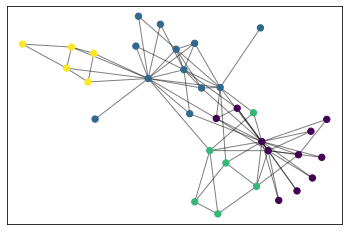

In [26]:
t0 = time()

# Computing best partition
G = load_graph('karate.txt')
partition, q = leiden_algorithm(G)

print(f'Time: {time() - t0}s')

# Plotting the partition
partition = community_to_dict(partition)
print(f'Best modularity found: {q}')
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

## DBLP Graph

In [28]:
G = load_graph('com-dblp.ungraph.txt')
nodes = list(G.nodes())

In [29]:
G_sub = G.subgraph(nodes[0:100])

Time: 30.817609310150146s
Best modularity found: 0.512645675228245


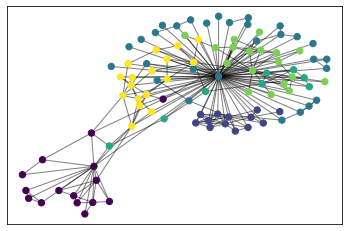

In [30]:
t0 = time()

partition, q = leiden_algorithm(G_sub)
partition = community_to_dict(partition)

print(f'Time: {time() - t0}s')

print(f'Best modularity found: {q}')


# draw the graph
pos = nx.spring_layout(G_sub)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_sub, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_sub, pos, alpha=0.5)
plt.show()